# Circuit of Quantum Fourier Transform using Qiskit

This notebook will teach you how to construct your own circuits for the Quantum Fourier Transform using Qiskit.

# Install Qiskit

Install Qiskit if you haven't. Here we are not installing the latest version of Qiskit since it has an issue with displaying circuits using matplotlib (fancy circuits) in Colab.

In [ ]:
!pip install qiskit==0.16.1

# Importing Packages

In [ ]:
from qiskit import * # No need to explain why
import matplotlib as mpl # Required to display some fancy circuits
import numpy as np

# The circuits

Now, we move on to main part of the notebook. In this section, we shall explain the construction of circuits for the Quantum Fourier Transform (QFT) acting on for 4 qubits. The QFT can be implemented using two types of gates, Hadamard and controlled-$R_k$, where controlled-$R_k$ is given as

\begin{equation}
  CR_k =
  \begin{bmatrix}
    1 & 0 & 0 & 0\\
    0 & 1 & 0 & 0\\
    0 & 0 & 1 & 0\\
    0 & 0 & 0 & e ^ {\frac{2 \pi i}{2 ^ k}}
  \end{bmatrix}
\end{equation}

Each of these $CR_k$ gates can be implemented using the controlled-$U1$ gate available in Qiskit, whose structure is given as 

\begin{equation}
  CU1({\phi}) =
  \begin{bmatrix}
    1 & 0 & 0 & 0\\
    0 & 1 & 0 & 0\\
    0 & 0 & 1 & 0\\
    0 & 0 & 0 & e ^ {i \phi}
  \end{bmatrix}
\end{equation}


# QFT on 4 qubits

Let $x = x_1 x_2 x_3 x_4$ be a bit string of length $4$. The QFT on $4$ qubits is the operator defined as 
\begin{equation}
  QFT|x_1x_2x_3x_4\rangle = \frac{1}{4} \sum \limits_{j = 0}^{15} e ^ {\frac{2 \pi i (j \cdot x)}{16}} |j\rangle
\end{equation}

The circuit for Quantum Fourier Transform on $4$ qubits is given as

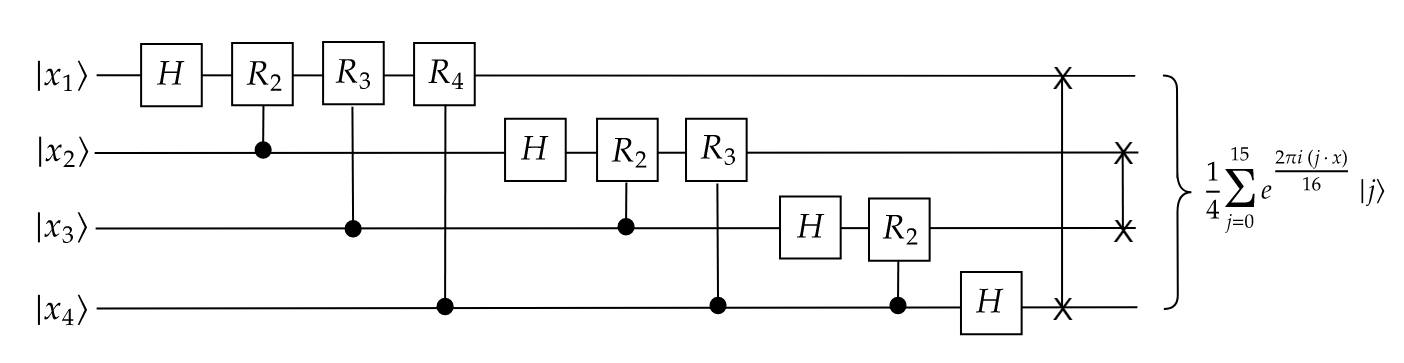

Now we move on to the construction of this circuit

First, we prepare the quantum register. As we can see, from the circuit, the quantum register comprises of 4 qubits. Hence

In [ ]:
# Prepare quantum register
qr = QuantumRegister(4)

Using the quantum register, we now define the quantum circuit

In [ ]:
# Prepare quantum circuit
qc = QuantumCircuit(qr)

Now, we shall start applying the gates. The first section of the circuit is to apply a $H$ gate on the most significant bit and a set of controlled-$U1$ gates targeted on the same qubit. 

In [ ]:
# Apply Hadamard gate on the most significant bit. Note that in Qiskit, the least signifcant qubit is qubit 0.
qc.h(3)

# Apply the sequence of controlled-U1 gates
qc.cu1(np.pi/2, 2, 3)
qc.cu1(np.pi/4, 1, 3)
qc.cu1(np.pi/8, 0, 3)

Let's visualize the circuit to see if we are on track

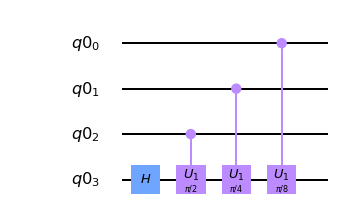

In [ ]:
qc.draw(output = "mpl")

Seems good. Now we'll move on to the next most significant qubit.

In [ ]:
# Apply Hadamard gate on the next most significant bit. 
qc.h(2)

# Apply the sequence of controlled-U1 gates
qc.cu1(np.pi/2, 1, 2)
qc.cu1(np.pi/4, 0, 2)

Are we still good?

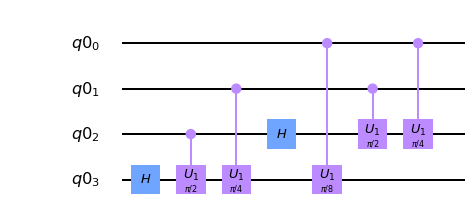

In [ ]:
qc.draw(output = "mpl")

Seems so. Now let's complete the circuit.

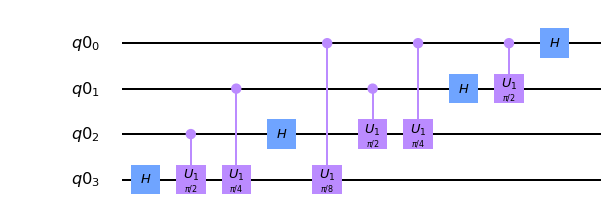

In [ ]:
# Apply Hadamard gate on the next most significant bit. 
qc.h(1)

# Apply the last controlled-U1 gate
qc.cu1(np.pi/2, 0, 1)

# Apply Hadamard gate on the least significant bit. 
qc.h(0)

# DIsplay the circuit
qc.draw(output = "mpl")

Now we shall apply the final two swap gates

In [ ]:
qc.swap(0,3)
qc.swap(1,2)

Now, let's visualize the final circuit

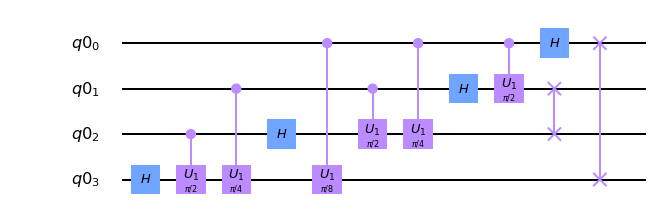

In [ ]:
qc.draw(output = "mpl")

We can see that we have constructed the required circuit.

## Validation

For validating our circuit, we apply this circuit on all the possible basis vectors, and compare the result with the Fourier transform matrix. For that, we first prepare the Fourier Transform matrix $F$, whose $(j,k)^{th}$ element is $\frac{1}{4} e ^ {\frac{2 \pi i j \cdot k}{16}}$

In [ ]:
DFT = np.zeros((16,16)) + (1j * np.zeros((16,16)))
for j in range(16):
  for k in range(16):
    DFT[j][k] = (1/4) * np.cos((2 * np.pi * j * k)/16) + (1j * (1/4) * np.sin((2 * np.pi * j * k)/16))

Now, lets apply our quantum circuit on the state $|8\rangle$. If our circuit was correct, then the output of the circuit should be the $9^{th}$ column of the $DFT$ matrix defined in the previous cell. So, we shall compute the norm of difference between the $2$ vectors, that is
\begin{equation}
  \Big| \Big| QFT|8\rangle - DFT[:,8]\Big| \Big|_2
\end{equation}
If this value is close to 0, then we start to have more confidence in our circuit.

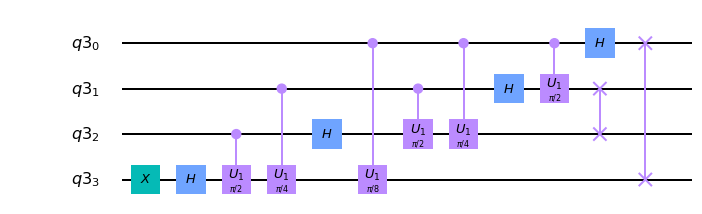

In [ ]:
# Prepare the circuit
qr = QuantumRegister(4)
qc = QuantumCircuit(qr)

# To prepare "8", we flip the most signifact qubit 
qc.x(3)

# Apply QFT
for j in range(3, -1, -1):
  qc.h(j)
  for k in range(j-1, -1, -1):
    qc.cu1(np.pi/(2 ** (j-k)), k, j)

for j in range(4):
  if j < 3 - j:
    qc.swap(j, 3 - j)

# Display the circuit
qc.draw(output = "mpl")

Next step is to extract the state associated with the output of this circuit.

In [ ]:
#Prepare the statevector
sv_sim = Aer.get_backend("statevector_simulator")
qobj = assemble(qc)
statevector = sv_sim.run(qobj).result().get_statevector()

Now lets compute the required norm

In [ ]:
np.linalg.norm(statevector - DFT[:,8])

2.00155435397263e-15

As expected, we see that the value is 0.

Now, we shall do a similar check on all basis states $|0\rangle, |1\rangle, \dots, |15\rangle$

In [ ]:
# This function converts a decimal number to its binary expansion
def Binary(x, BitNo):
  format(x, 'b').zfill(BitNo)
  Binlist = [int(y) for y in list(format(x, 'b').zfill(BitNo))]
  return Binlist
 
for i in range(16):
  # Compute the binary expansion of i
  bin_list = Binary(i, 4)

  # Reverse the output since Qiskit considers the least significant bit to be the leftmost.
  bin_list.reverse()

  # Prepare the circuit
  qr = QuantumRegister(4)
  qc = QuantumCircuit(qr)
  
  # Prepare the state associated with i
  for j in range(4):
    if bin_list[j] == 1:
      qc.x(j)

  # Apply QFT
  for j in range(3, -1, -1):
    qc.h(j)
    for k in range(j-1, -1, -1):
      qc.cu1(np.pi/(2 ** (j-k)), k, j)

  for j in range(4):
    if j < 3 - j:
      qc.swap(j, 3 - j)
    
  # Extract the statevector
  sv_sim = Aer.get_backend("statevector_simulator")
  qobj = assemble(qc)
  statevector = sv_sim.run(qobj).result().get_statevector()

  # Display the norm of difference
  print("Norm of difference for the state associated with {} is {}".format(i, np.linalg.norm(statevector - DFT[:,i])))

Norm of difference for the state associated with 0 is 1.8619006149354548e-16
Norm of difference for the state associated with 1 is 2.7642031143914395e-16
Norm of difference for the state associated with 2 is 4.852076296768613e-16
Norm of difference for the state associated with 3 is 1.0264563870366807e-15
Norm of difference for the state associated with 4 is 9.668236138332222e-16
Norm of difference for the state associated with 5 is 1.1813174348332444e-15
Norm of difference for the state associated with 6 is 2.1765845287053904e-15
Norm of difference for the state associated with 7 is 2.535529666072179e-15
Norm of difference for the state associated with 8 is 2.00155435397263e-15
Norm of difference for the state associated with 9 is 2.0192271666902548e-15
Norm of difference for the state associated with 10 is 2.4913489215876042e-15
Norm of difference for the state associated with 11 is 3.465565731408201e-15
Norm of difference for the state associated with 12 is 4.560494341415664e-15
Nor

Seeing that all the possible norm differnces are $0$, we can safely conclude that our circuit is indeed the Quantum Fourier Transform acting on $4$ qubits.

The code snippet given below prepares and executes a Quantum Fourier Transform on any number of qubits and validates the result after that.

In [ ]:
number_of_qubits = 3

# Prepare the Fourier Transform matrix for validation later
DFT = np.zeros((2 ** number_of_qubits,2 ** number_of_qubits)) + (1j * np.zeros((2 ** number_of_qubits,2 ** number_of_qubits)))
for k1 in range(2 ** number_of_qubits):
  for k2 in range(2 ** number_of_qubits):
    DFT[k1][k2] = (1/np.sqrt(2 ** number_of_qubits)) * np.cos((2 * np.pi * k1 * k2)/2 ** number_of_qubits) + (1j * (1/np.sqrt(2 ** number_of_qubits)) * np.sin((2 * np.pi * k1 * k2)/2 ** number_of_qubits))


for i in range(2 ** number_of_qubits):

  # Compute the binary expansion of i
  bin_list = Binary(i, number_of_qubits)

  # Reverse the output since Qiskit considers the least significant bit to be the leftmost.
  bin_list.reverse()

  # Prepare the circuit
  qr = QuantumRegister(number_of_qubits)
  qc = QuantumCircuit(qr)

  # Prepare the state associated with i
  for j in range(number_of_qubits):
    if bin_list[j] == 1:
      qc.x(j)

  # Apply QFT
  for j in range(number_of_qubits - 1, -1, -1):
    qc.h(j)
    for k in range(j-1, -1, -1):
      qc.cu1(np.pi/(2 ** (j-k)), k, j)

  for j in range(number_of_qubits):
    if j < number_of_qubits - j - 1:
      qc.swap(j, number_of_qubits - j - 1)
    
  # Extract the statevector
  sv_sim = Aer.get_backend("statevector_simulator")
  qobj = assemble(qc)
  statevector = sv_sim.run(qobj).result().get_statevector()

  # Display the norm of difference
  print("Norm of difference for the state associated with {} is {}".format(i, np.linalg.norm(statevector - DFT[:,i])))


Norm of difference for the state associated with 0 is 1.5700924586837752e-16
Norm of difference for the state associated with 1 is 1.838311904685805e-16
Norm of difference for the state associated with 2 is 2.1713659301942747e-16
Norm of difference for the state associated with 3 is 4.79404755074576e-16
Norm of difference for the state associated with 4 is 4.4398679968470933e-16
Norm of difference for the state associated with 5 is 1.1048160421665868e-15
Norm of difference for the state associated with 6 is 9.786765733076592e-16
Norm of difference for the state associated with 7 is 1.4371134794117689e-15
